# Classification Trees in Python, From Start to Finish

In this lesson we will use **scikit-learn** and **Cost Complexity Pruning** to build this **Classification Tree**, which uses continuous and categorical data from the **[UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php)** to predict whether or not a patient has **[heart disease](https://archive.ics.uci.edu/ml/datasets/Heart+Disease)**:

<img src="data\imgs\tree.png" alt="A Classification Tree" style="width: 600px;">

In this lesson you will learn about...

- **[Importing the Data From a File](#download-the-data)**

- **[Missing Data](#identify-and-deal-with-missing-data)**
    - Identifying Missing Data
    - Dealing with Missing Data
    

- **[Formatting the Data for Decision Trees](#format-the-data)**
    - Split data into Dependent and Independent Variables
    - One-Hot-Encoding
    

- **[Building a Preliminary Classification Tree](#build-tree)**

- **[Using Cost Complexity Pruning](#prune-tree)**
    - Visualize Alpha
    - Cross Validation For Finding the Best Alpha


- **[Building, Drawing, Interpreting and Evaluating the Final Classification Tree](#draw-tree)**

# Task 1: Import the modules that will do all the work
These modules give us extra functionality to import the data, clean it up and format it, and then build, evaluate and draw the classification tree. 
- pandas >= 0.25.1
- numpy >= 1.17.2
- sklearn >= 0.22.1

In [2]:
import pandas as pd # load and manipulate data and for One-Hot Encoding
import numpy as np # calculate the mean and standard deviation
import matplotlib.pyplot as plt # drawing graphs
from sklearn.tree import DecisionTreeClassifier # a classification tree
from sklearn.tree import plot_tree # draw a classification tree
from sklearn.model_selection import train_test_split # split  data into training and testing sets
from sklearn.model_selection import cross_val_score # cross validation
from sklearn.metrics import confusion_matrix # creates a confusion matrix
from sklearn.metrics import plot_confusion_matrix # draws a confusion matrix

----
<a id="download-the-data"></a>
# Task 2: Import the data
Now we load in a dataset from the **[UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php)**.
Specifically, we are going to use the **[Heart Disease Dataset](https://archive.ics.uci.edu/ml/datasets/Heart+Disease)**. This dataset will allow us to predict if someone has heart disease based on their sex, age, blood pressure and a variety of other metrics.

In [5]:
df = pd.read_csv('processed.cleveland.data', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


Update column names:
- **age**,
- **sex**,
- **cp**, chest pain
- **restbp**, resting blood pressure (in mm Hg)
- **chol**, serum cholesterol in mg/dl
- **fbs**, fasting blood sugar
- **restecg**, resting electrocardiographic results
- **thalach**,  maximum heart rate achieved
- **exang**, exercise induced angina
- **oldpeak**, ST depression induced by exercise relative to rest
- **slope**, the slope of the peak exercise ST segment.
- **ca**, number of major vessels (0-3) colored by fluoroscopy
- **thal**, this is short of thalium heart scan.
- **hd**, diagnosis of heart disease, the predicted attribute

In [6]:
df.columns = ['age', 
              'sex', 
              'cp', 
              'restbp', 
              'chol', 
              'fbs', 
              'restecg', 
              'thalach', 
              'exang', 
              'oldpeak', 
              'slope', 
              'ca', 
              'thal', 
              'hd']
df.head()

,age,sex,cp,restbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,hd
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


----
<a id="identify-and-deal-with-missing-data"></a>
# Task 3: Missing Data Part 1: Identifying Missing Data
The biggest part of any data analysis project is making sure that the data is correctly formatted and fixing it when it is not. The first part of this process is dealing with **Missing Data**.

There are two main ways to deal with missing data:
1. We can remove the rows that contain missing data from the dataset. 
2. We can **impute** the values that are missing. 

In this section, we'll focus on identifying missing values in the dataset and dealing with them. 

First, let's see what sort of data is in each column.

In [9]:
df.dtypes

age        float64
sex        float64
cp         float64
restbp     float64
chol       float64
fbs        float64
restecg    float64
thalach    float64
exang      float64
oldpeak    float64
slope      float64
ca          object
thal        object
hd           int64
dtype: object

Let's check the statistical description of the numerical features

In [11]:
df.describe().applymap('{:,.2f}'.format)

,age,sex,cp,restbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,hd
count,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00
mean,54.44,0.68,3.16,131.69,246.69,0.15,0.99,149.61,0.33,1.04,1.60,0.94
std,9.04,0.47,0.96,17.60,51.78,0.36,0.99,22.88,0.47,1.16,0.62,1.23
min,29.00,0.00,1.00,94.00,126.00,0.00,0.00,71.00,0.00,0.00,1.00,0.00
25%,48.00,0.00,3.00,120.00,211.00,0.00,0.00,133.50,0.00,0.00,1.00,0.00
50%,56.00,1.00,3.00,130.00,241.00,0.00,1.00,153.00,0.00,0.80,2.00,0.00
75%,61.00,1.00,4.00,140.00,275.00,0.00,2.00,166.00,1.00,1.60,2.00,2.00
max,77.00,1.00,4.00,200.00,564.00,1.00,2.00,202.00,1.00,6.20,3.00,4.00


Numerical data does not have any values missing. Let's check the **ca** and **thal** columns.

In [15]:
df['ca'].unique()

array(['0.0', '3.0', '2.0', '1.0', '?'], dtype=object)

In [16]:
df['thal'].unique()

array(['6.0', '3.0', '7.0', '?'], dtype=object)

----

# Task 4: Missing Data Part 2: Dealing With Missing Data

First let's see how many rows contain missing values.

In [18]:
print("Missing 'ca' values: ", len(df[df['ca'] == '?']))

4

In [21]:
print("Missing 'thal' values: ", len(df[df['thal'] == '?']))

2

Let's look at the rows with the missing values.

In [29]:
df[np.logical_or(df['ca'] == '?',df['thal'] == '?')]

,age,sex,cp,restbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,hd
87,53.0,0.0,3.0,128.0,216.0,0.0,2.0,115.0,0.0,0.0,1.0,0.0,?,0
166,52.0,1.0,3.0,138.0,223.0,0.0,0.0,169.0,0.0,0.0,1.0,?,3.0,0
192,43.0,1.0,4.0,132.0,247.0,1.0,2.0,143.0,1.0,0.1,2.0,?,7.0,1
266,52.0,1.0,4.0,128.0,204.0,1.0,0.0,156.0,1.0,1.0,2.0,0.0,?,2
287,58.0,1.0,2.0,125.0,220.0,0.0,0.0,144.0,0.0,0.4,2.0,?,7.0,0
302,38.0,1.0,3.0,138.0,175.0,0.0,0.0,173.0,0.0,0.0,1.0,?,3.0,0


So 6 of the **303** rows, or **2%**, contain missing values. Since **303 - 6 = 297**, and **297** is plenty of data to build a classification tree, we will remove the rows with missing values, rather than try to impute their values.

In [30]:
df_no_missing = df[np.logical_and(df['ca']!='?',df['thal']!='?')]

We can also make sure **ca** and **thal** no longer contains question marks by printing its unique values:

In [31]:
print(df_no_missing['ca'].unique())
print(df_no_missing['thal'].unique())

['0.0' '3.0' '2.0' '1.0']
['6.0' '3.0' '7.0']


**NOTE: ca** and **thal** still have the object data type. 

----
<a id="format-the-data"></a>
# Task 5: Format Data Part 1: Split the Data into Dependent and Independent Variables

The first step is to split the data into two parts:
1. The columns of data that we will use to make classifications
2. The column of data that we want to predict.

In this case, we want to predict **hd** (heart disease).

The reason we deal with missing data before splitting it into **X** and **y** is that if we remove rows, splitting after ensures that each row in **X** correctly corresponds with the appropriate value in **y**.

**NOTE:** In the code below we are using `copy()` to copy the data *by value*. By default, pandas uses copy *by reference*. Using `copy()` ensures that the original data `df_no_missing` is not modified when we modify `X` or `y`. In other words, if we make a mistake when we are formatting the columns for classification trees, we can just re-copy `df_no_missing`, rather than have to reload the original data and  remove the missing values etc.

In [34]:
X = df_no_missing.drop('hd', axis=1).copy()
y = df_no_missing['hd'].copy()

----
<a id="one-hot-encoding"></a>
# Task 6: Format the Data Part 2: One-Hot Encoding

Now we need to take a closer look at the variables in `X`. The list bellow tells us what each variable represents and the type of data (**float** or **categorical**) it should contain:

- **age**, **Float**
- **sex** - **Category**
  - 0 = female
  - 1 = male
- **cp**, chest pain, **Category**
  - 1 = typical angina,
  - 2 = atypical angina,
  - 3 = non-anginal pain,
  - 4 = asymptomatic
- **restbp**, resting blood pressure (in mm Hg), **Float**
- **chol**, serum cholesterol in mg/dl, **Float**
- **fbs**, fasting blood sugar, **Category**
  - 0 = >=120 mg/dl
  - 1 = <120 mg/dl
- **restecg**, resting electrocardiographic results, **Category**
  - 1 = normal
  - 2 = having ST-T wave abnormality
  - 3 = showing probable or definite left ventricular hypertrophy
- **thalach**,  maximum heart rate achieved, **Float**
- **exang**, exercise induced angina, **Category**
  - 0 = no
  - 1 = yes
- **oldpeak**, ST depression induced by exercise relative to rest. **Float**
- **slope**, the slope of the peak exercise ST segment, **Category**
  - 1 = upsloping
  - 2 = flat
  - 3 = downsloping
- **ca**, number of major vessels (0-3) colored by fluoroscopy, **Float**
- **thal**, thalium heart scan, **Category**
  - 3 = normal (no cold spots)
  - 6 = fixed defect (cold spots during rest and exercise)
  - 7 = reversible defect (when cold spots only appear during exercise)


In [35]:
X.dtypes

age        float64
sex        float64
cp         float64
restbp     float64
chol       float64
fbs        float64
restecg    float64
thalach    float64
exang      float64
oldpeak    float64
slope      float64
ca          object
thal        object
dtype: object

So, we see that **age**, **restbp**, **chol** and **thalach** are all `float64`, which is good, because we want them to be floating point numbers. All of the other columns, however, need to be inspected to make sure they only contain reasonable values, and some of them need to change. This is because, while **scikit learn Decision Trees** natively support continuous data, like resting blood preasure (**restbp**) and maximum heart rate (**thalach**), they do not natively support categorical data, like chest pain (**cp**), which contains 4 different categories. Thus, in order to use categorical data with **scikit learn Decision Trees**, we have to use a trick that converts a column of categorical data into multiple columns of binary values. This trick is called **One-Hot Encoding**.

At this point you may be wondering, "what's wrong with treating categorical data like continuous data?" To answer that question, let's look at an example: For the **cp** (chest pain) column, we have 4 options:
1. typical angina,
2. atypical angina,
3. non-anginal pain,
4. asymptomatic

Our categorical data is not ordinal, hence we will end up with splits that do not make sense. If we treated these values, 1, 2, 3 and 4, like continuous data, then we would assume that 4, which means "asymptomatic", is more similar to 3, which means "non-anginal pain", than it is to 1 or 2, which are other types of chest pain. Thus, the decision tree would be more likely to cluster the patients with 4s and 3s together than the patients with 4s and 1s together. In contrast, if we treat these numbers like categorical data, then we treat each one a separate category that is no more or less similar to any of the other categories. Thus, the likelihood of clustering patients with 4s with 3s is the same as clustering 4s with 1s, and that approach is more reasonable.

Now let's inspect and, if needed, convert the columns that contain categorical and integer data into the correct datatypes. We'll start with **cp** (chest pain) by inspecting all of its unique values:

In [38]:
X['cp'].unique()

array([1., 4., 3., 2.])

**NOTE:** There are many different ways to do **One-Hot Encoding** in Python. Two of the more popular methods are `ColumnTransformer()` (from **scikit-learn**) and `get_dummies()` (from **pandas**), and the both methods have pros and cons. `ColumnTransformer()` has a very cool feature where it creates a persistent function that can validate data that you get in the future. For example, if you build your **Decision Tree** using a categorical variable **favorite color** that has **red**, **blue** and **green** options, then `ColumnTransformer()` can remember those options and later on when your **Decision Tree** is being used in a production system, if someone says their favorite color is **orange**, then `ColumnTransformer()` can throw an error or handle the situation in some other nice way. The downside of `ColumnTransformer()` is that it turns your data into an array and looses all of the column names, making it harder to verify that your usage of `ColumnTransformer()` worked as you intended it to. In contrast, `get_dummies()` leaves your data in a dataframe and retains the column names, making it much easier to verify that it worked as intended. However, it does not have the persistent behavior that `ColumnTransformer()` has. 

First, before we commit to converting **cp** with **One-Hot Encoding**, let's just see what happens when we convert **cp** without saving the results. This will just make it easy to see how `get_dummies()` works.

In [39]:
pd.get_dummies(X, columns=['cp']).head()

,age,sex,restbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,cp_1.0,cp_2.0,cp_3.0,cp_4.0
0,63.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,1,0,0,0
1,67.0,1.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,0,0,0,1
2,67.0,1.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,0,0,0,1
3,37.0,1.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0,1,0
4,41.0,0.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,1,0,0


Let's use it on the four categorical columns that have more than 2 categories and save the result.
**NOTE:** In practice you should verify all 5 of these columns to make sure they only contain
the accepted categories.

In [41]:
X_encoded = pd.get_dummies(X, columns=['cp','restecg','slope','thal'])
X_encoded.head()

,age,sex,restbp,chol,fbs,thalach,exang,oldpeak,ca,cp_1.0,...,cp_4.0,restecg_0.0,restecg_1.0,restecg_2.0,slope_1.0,slope_2.0,slope_3.0,thal_3.0,thal_6.0,thal_7.0
0,63.0,1.0,145.0,233.0,1.0,150.0,0.0,2.3,0.0,1,...,0,0,0,1,0,0,1,0,1,0
1,67.0,1.0,160.0,286.0,0.0,108.0,1.0,1.5,3.0,0,...,1,0,0,1,0,1,0,1,0,0
2,67.0,1.0,120.0,229.0,0.0,129.0,1.0,2.6,2.0,0,...,1,0,0,1,0,1,0,0,0,1
3,37.0,1.0,130.0,250.0,0.0,187.0,0.0,3.5,0.0,0,...,0,1,0,0,0,0,1,1,0,0
4,41.0,0.0,130.0,204.0,0.0,172.0,0.0,1.4,0.0,0,...,0,0,0,1,1,0,0,1,0,0


**One-Hot Encoding** converts a column with more than **2** categories. Since **sex**, **fbs**, and **exang** only have **2** categories and only contain **0**s and **1**s to begin with, we do not have to do anything special to them, so we're done formatting the data for the **Classification Tree**.

Now, one last thing before we build a Classification Tree.  `y` doesn't just contain **0**s and **1**s. Instead, it has **5** different levels of heart disease. **0 =** no heart disease and **1-4** are various degrees of heart disease.
Since we're only making a tree that does simple classification and only care if someone has heart disease or not, we need to convert all numbers **> 0** to **1**.

In [42]:
y[y>0] = 1
y.unique()

array([0, 1], dtype=int64)

<a id="build-tree"></a>
# Task 7: Build A Preliminary Classification Tree
At long last, the data is correctly formatted for making a **Classification Tree**. Now we simply split the data into **training** and **testing** sets and build the tree.

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
clf_dt = DecisionTreeClassifier(random_state=42)
clf_dt = clf_dt.fit(X_train, y_train)

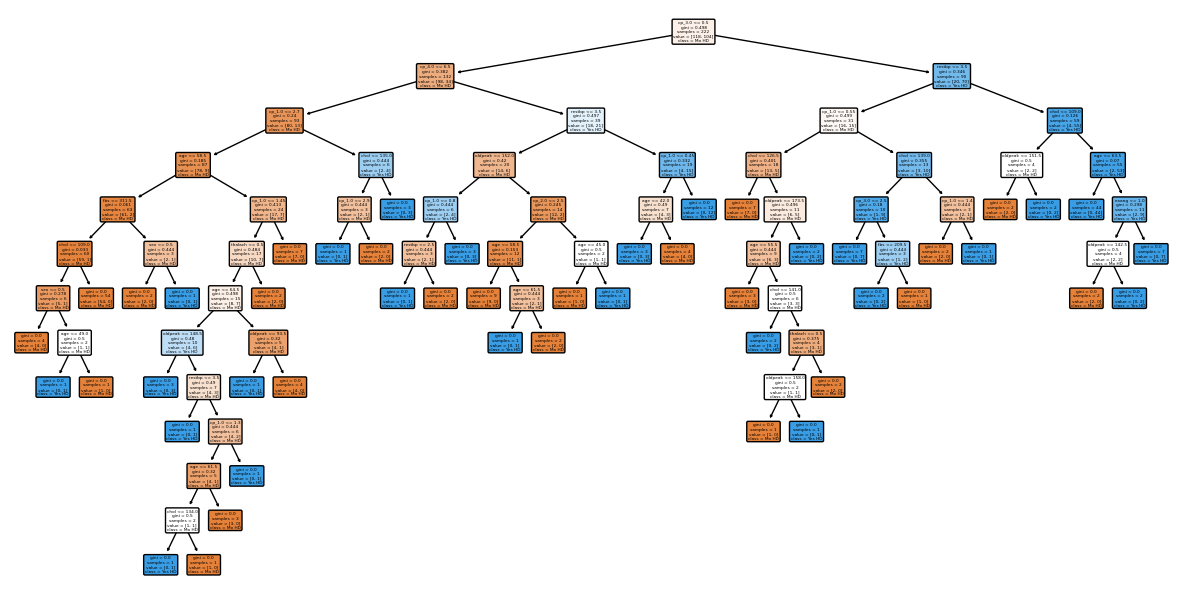

In [48]:
plt.figure(figsize=(15, 7.5))
plot_tree(clf_dt, 
          filled=True, 
          rounded=True, 
          class_names=["Mo HD", "Yes HD"], 
          feature_names=X_encoded.columns)
plt.show()

OK, we've built a **Classification Tree** for classification. Let's see how it performs on the **Testing Dataset** by running the **Testing Dataset** down the tree and drawing a **Confusion Matrix**.

C:\Python37\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


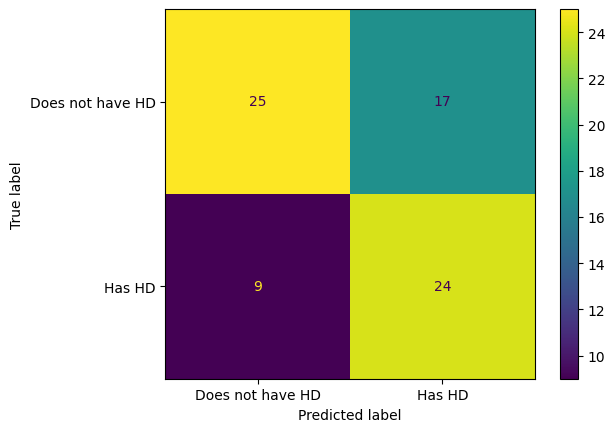

In [44]:
plot_confusion_matrix(clf_dt, X_test, y_test, display_labels=['Does not have HD', 'Has HD']);

----
<a id="prune-tree"></a>
# Task 8: Cost Complexity Pruning Part 1: Visualize alpha

**Decision Trees** are notorious for being **overfit** to the **Training Dataset**, so let's prune this tree in hopes that we can improve the accuracy with the **Testing Dataset**.

Pruning a decision tree is all about finding the right value for the pruning parameter, `alpha`, which controls how little or how much pruning happens. One way to find the optimal value for `alpha` is to plot the accuracy of the tree as a function of different values for `alpha`.  We'll do this for both the **Training Dataset** and the **Testing Dataset**.

First, let's extract the different values of `alpha` that are available for this tree and build a pruned tree for each value for `alpha`. **NOTE:** We omit the maximum value for alpha because it would prune all leaves, leaving us with only a root instead of a tree, with the following: `ccp_alphas = ccp_alphas[:-1]`.

In [49]:
path = clf_dt.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
ccp_alphas = ccp_alphas[:-1]
print(ccp_alphas, impurities)

clf_dts = []
for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf_dt.fit(X_train, y_train)
    clf_dts.append(clf_dt)

[0.         0.00295295 0.00337838 0.0036036  0.003861   0.00405405
 0.0041184  0.00429358 0.00541298 0.00563063 0.00578761 0.00600601
 0.00600601 0.00600601 0.00655201 0.00667591 0.00757375 0.00796251
 0.00811505 0.01038181 0.0105777  0.01422475 0.01604051 0.01642461
 0.02103075 0.03680006 0.03934523] [0.         0.00885886 0.01561562 0.02282282 0.03826684 0.04637495
 0.05461175 0.06319891 0.08485082 0.09611208 0.1134749  0.12548691
 0.13749892 0.14350493 0.15005693 0.15673284 0.16430659 0.1722691
 0.18849919 0.19888101 0.2094587  0.2379082  0.25394872 0.27037333
 0.29140408 0.32820413 0.36754937 0.49801153]


Now let's graph the accuracy of the trees using the **Training Dataset** and the **Testing Dataset** as a function of alpha.

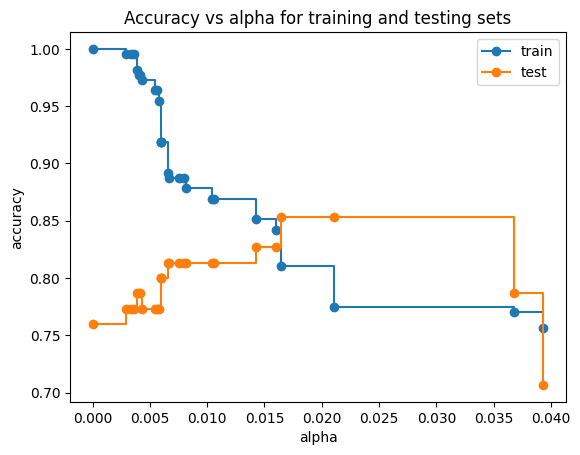

In [50]:
train_scores = [clf_dt.score(X_train, y_train) for clf_dt in clf_dts]
test_scores = [clf_dt.score(X_test, y_test) for clf_dt in clf_dts]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test", drawstyle="steps-post")
ax.legend()
plt.show()

In the graph above, we see that the accuracy for the Testing Dataset hits its maximum value when alpha is about 0.016. After this value for alpha, the accuracy of the Training Dataset drops off and that suggest we should set ccp_alpha=0.016.

However, since there are many ways we could have divided the original dataset into Training and Testing datasets, how do we know we used the best Training Dataset and how do we know we used the best Testing Dataset? Typically, we answer this question with 10-Fold Cross Validation. So that's what we're going to do now, and we'll do it with the cross_val_score() function.

----
# Task 9: Cost Complexity Pruning Part 2: Cross Validation For Finding the Best Alpha

The graphs we just drew suggest one value for alpha, **0.016**, but another
set of data might suggest another optimal value. 

<!-- **Terminology Alert!!!** Since, ultimately, we have to decide on one value for `alpha`, and
the **Decision Tree** algorithm will not do this for us, `alpha` is called a **Hyperparameter** to differentiate it from the parameters that the **Decision Tree** algorithm can take care of on its own. -->

First, let's demonstrate that different training and testing datasets result in trees with different accuracies:

<AxesSubplot:xlabel='tree'>

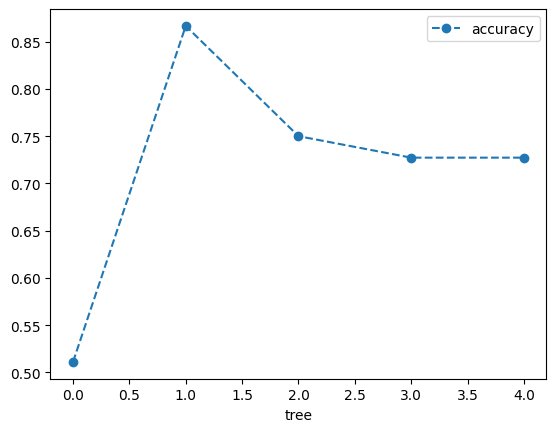

In [53]:
clf_dt = DecisionTreeClassifier(random_state=42, ccp_alpha=0.016)
scores = cross_val_score(clf_dt, X_train, y_train, cv=5)
df = pd.DataFrame(data={'tree': range(5), 'accuracy': scores})
df.plot(x='tree', y='accuracy', marker='o', linestyle='--')

So we see that using different **Training** and **Testing** data results in different accuracies.

Now let's use **cross validation** to find the optimal value for `ccp_alpha`.

<AxesSubplot:xlabel='alpha'>

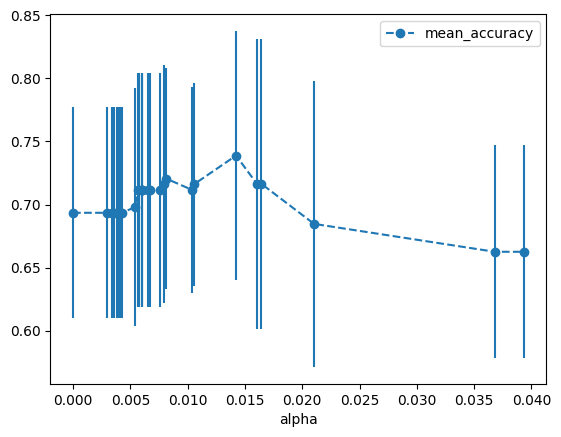

In [54]:
alpha_loop_values = []
for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    scores = cross_val_score(clf_dt, X_train, y_train, cv=5)
    alpha_loop_values.append([ccp_alpha, np.mean(scores), np.std(scores)])
    
alpha_results = pd.DataFrame(alpha_loop_values, 
                             columns=['alpha', 'mean_accuracy', 'std'])

alpha_results.plot(x='alpha', 
                   y='mean_accuracy', 
                   yerr='std', 
                   marker='o', 
                   linestyle='--')

Using cross validation, we can see that, over all, instead of setting `ccp_alpha=0.016`,  we need to set it to something closer to **0.014**. We can find the exact value with:

Now let's store the ideal value for alpha so that we can use it to build the best tree.

In [60]:
ideal_ccp_alpha = alpha_results[np.logical_and(alpha_results['alpha']> 0.014, alpha_results['alpha']<0.015)]['alpha']
ideal_ccp_alpha

21    0.014225
Name: alpha, dtype: float64

**NOTE** At this point Python thinks that `ideal_ccp_alpha` is a `series`. We can tell because when we printed `ideal_ccp_alpha` out, we got two bits of stuff. The first one was `20`, which is the index in the series, the second one, `0.014225`, is the value we want. So we can convert this from a series to a float with the following command:

In [61]:
ideal_ccp_alpha = float(ideal_ccp_alpha)
ideal_ccp_alpha

0.014224751066856332

----
<a id="draw-tree"></a>
# Task 10: Building, Evaluating, Drawing, and Interpreting the Final Classification Tree

Now that we have the ideal value for `alpha` we can build the final **Classification Tree** by setting `ccp_alpha`:

In [63]:
clf_dt_pruned = DecisionTreeClassifier(random_state=42, ccp_alpha=ideal_ccp_alpha)
clf_dt_pruned = clf_dt_pruned.fit(X_train, y_train) 

Now let's draw another confusion matrix to see if the pruned tree does better.

C:\Python37\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


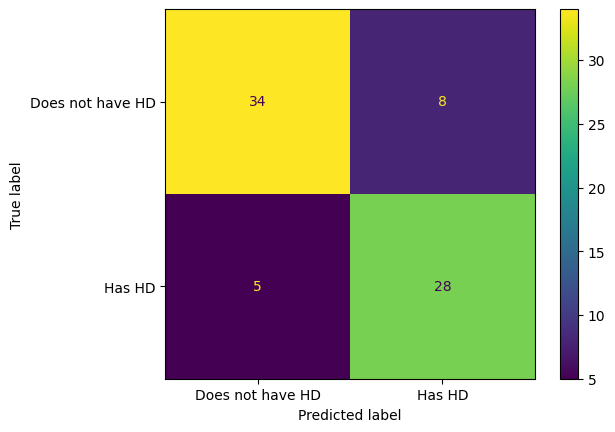

In [64]:
plot_confusion_matrix(clf_dt_pruned, 
                      X_test, 
                      y_test, 
                      display_labels=["Does not have HD", "Has HD"])

In [66]:
clf_dt_pruned.score(X_train, y_train)

0.8513513513513513

The last thing we are going to do is draw the pruned tree and discuss how to interpret it.

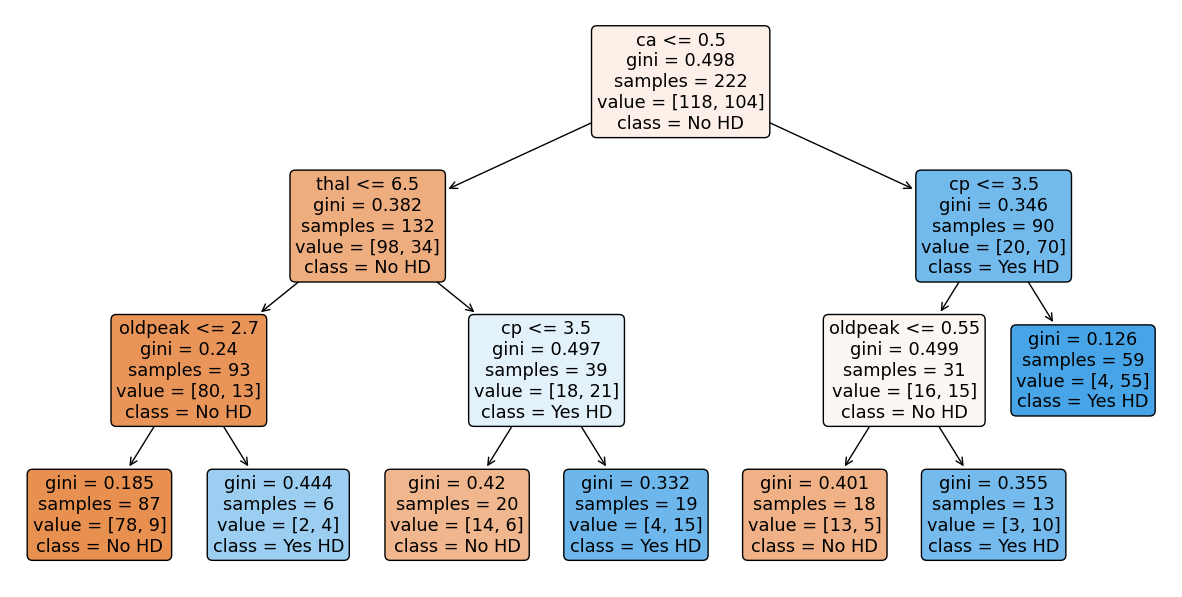

In [68]:
plt.figure(figsize=(15,7.5))
plot_tree(clf_dt_pruned, 
          filled=True, 
          rounded=True, 
          class_names=["No HD", "Yes HD"], 
          feature_names=X.columns);

Now let's discuss how to interpret the tree.
In each node, we have:
- The variable (column name) and the threshold for splitting the observations. For example, in the tree's root, we use **ca** to split the observations. All
observations with **ca <= 0.5** go to the **left** and all observations with **ca > 0.5** go to the **right**.
- **gini** is the gini index or score for that node
- **samples** tell us how many samples are in that node
- **value** tells us how many samples in the node are in each category. In this example, we have two categories, **No** and **Yes**, referring to whether or not a patient has heart disease. The number of patients with **No** comes first because the categories are in alphabetical order. Thus, in the root, 118 patients have **No** and 104 patients have **Yes**.
- **class** tells us whichever category is represented most in the node. In the root, since 118 people have **No** and only 104 people have **Yes**, class is set to **No**.

The leaves are just like the nodes, except that they do not contain a variable and threshold for splitting the observations.

The nodes and leaves are colored by the **class**. In this case **No** is different shades of orange-ish and **Yes** is different shades of blue. The the darker the shade, the lower the **gini** score, and that tells us how much the node or leaf is skewed towards one class.

# In conclusion we...

- **[Loaded the Data From a File](#download-the-data)**

- **[Identified and Dealt with Missing Data](#identify-and-deal-with-missing-data)**

- **[Formatted the Data for Decision Trees using One-Hot Encoding](#one-hot-encoding)**

- **[Built a Decision Tree for Classification](#build-tree)**

- **[Pruned the Decision Tree with Cost Complexity Pruning](#prune-tree)**

- **[Built, Drew, Interpreted and Evaluated the Final Decision Tree](#draw-tree)**

----
# Lesson Learned
- if dealing with numerical values, to check missing, use .describe
- if dealing with object values, to check missing, use .unique


skitlearn does not handle categorical data.
-> if data is not ordinal (sorted) it should not be considered as numerical
-> use one hot encoding. ColumnTransformer or pandas get_dummies

